# Importando módulos 

In [111]:
import obspy
from obspy.taup import TauPyModel

from multiprocessing import Pool
from obspy import read,UTCDateTime,Trace,read_inventory,read_events
from obspy.imaging.beachball import beachball,beach
from obspy.clients.fdsn import Client
import os
import glob
import numpy as np
from collections import defaultdict
import pandas as pd
from scipy import signal
import subprocess


#para plotar as figuras
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.transforms import offset_copy
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition,inset_axes
import matplotlib.cm as cm
from matplotlib.dates import YearLocator, MonthLocator, DayLocator, HourLocator, MinuteLocator, SecondLocator, DateFormatter
from matplotlib.ticker import MultipleLocator, FormatStrFormatter,FixedLocator,StrMethodFormatter

import matplotlib.colors as mcolors

from datetime import datetime,timedelta,date
from tqdm import tqdm

from shapely.geometry.polygon import LinearRing

import cartopy.io.shapereader as shpreader
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter,LatitudeFormatter
import requests
import csv
import xml.etree.ElementTree as ET

# Inputs e Outputs Directories

In [112]:
#FOLDER_OUTPUT = '/home/sysop/dados_posdoc/GLIDER_PETROBRAS/OUTPUT/'
#MSEED_INPUT = "/home/sysop/dados_posdoc/GLIDER_PETROBRAS/DATA/"
#EVENTS_FILES = "/home/sysop/dados_posdoc/GLIDER_PETROBRAS/DATA_EVENTS/"
#EVENTS_GLIDER_FILES = "/home/sysop/dados_posdoc/GLIDER_PETROBRAS/OUTPUT/EVENTS_GLIDERS/"
#QUAKEXML_FOLDER = '/home/sysop/dados_posdoc/GLIDER_PETROBRAS/OUTPUT/EVENTS/'
#XML_FILE = '/home/sysop/dados_posdoc/GLIDER_PETROBRAS/XML/glider_nettab_per_dive.xml'
#METADATA_FILE = '/home/sysop/dados_posdoc/GLIDER_PETROBRAS/METADATA/df_campanha_glider.feather'
#MODEL_CAKE = '/home/sysop/dados_posdoc/GLIDER_PETROBRAS/EARTH_MODEL_AREA/model_ak135_SOFAR.nd'
#LOCAL_EVENTS_TABLE = "/media/sysop/14f7ead0-5dcb-4557-a139-55dbb404d11a/diogoloc/dados_posdoc/Gliders_DATA/event_files/iag_catalogo_costa.csv"

# --------------------------------------------------------------------------------------------
LOCAL_EVENTS_TABLE = "/media/sysop/14f7ead0-5dcb-4557-a139-55dbb404d11a/diogoloc/dados_posdoc/Gliders_DATA/event_files/iag_catalogo_costa.csv"
FOLDER_OUTPUT = '/media/sysop/14f7ead0-5dcb-4557-a139-55dbb404d11a/diogoloc/dados_posdoc/Gliders_DATA/OUTPUT/'
MSEED_INPUT = "/media/sysop/14f7ead0-5dcb-4557-a139-55dbb404d11a/diogoloc/dados_posdoc/Gliders_DATA/DATA/"
EVENTS_FILES = "/media/sysop/14f7ead0-5dcb-4557-a139-55dbb404d11a/diogoloc/dados_posdoc/Gliders_DATA/OUTPUT/DATA_EVENTS/"
EVENTS_GLIDER_FILES = "/media/sysop/14f7ead0-5dcb-4557-a139-55dbb404d11a/diogoloc/dados_posdoc/Gliders_DATA/OUTPUT/EVENTS_GLIDERS/"
QUAKEXML_FOLDER = '/media/sysop/14f7ead0-5dcb-4557-a139-55dbb404d11a/diogoloc/dados_posdoc/Gliders_DATA/OUTPUT/EVENTS/'
XML_FILE = '/media/sysop/14f7ead0-5dcb-4557-a139-55dbb404d11a/diogoloc/dados_posdoc/Gliders_DATA/XML/glider_nettab_per_dive.xml'
METADATA_FILE = '/media/sysop/14f7ead0-5dcb-4557-a139-55dbb404d11a/diogoloc/dados_posdoc/Gliders_DATA/METADATA/df_campanha_glider.feather'
MODEL_CAKE = '/media/sysop/14f7ead0-5dcb-4557-a139-55dbb404d11a/diogoloc/dados_posdoc/Gliders_DATA/EARTH_MODEL_AREA/model_ak135_SOFAR.nd'

# Looking for stations files:

In [113]:
selected_events = glob.glob(EVENTS_FILES+'*/*/*/*/*')

In [114]:
ev_lst = []
for ev_time_path in selected_events:
    ev_lst.append(ev_time_path.split('/')[-1])

In [115]:
ev_time_lst = sorted(list(set(ev_lst)))

In [116]:
ev_time_lst

['2017.105.08.19.43.00',
 '2017.165.07.29.06.00',
 '2017.356.08.44.36.00',
 '2019.295.06.15.47.601',
 '2019.300.07.20.11.573',
 '2019.341.12.18.54.900',
 '2020.014.23.19.00.00',
 '2020.051.08.03.31.741',
 '2020.085.11.30.39.697',
 '2020.092.11.34.35.840',
 '2020.121.19.26.18.813',
 '2020.138.23.20.53.00']

In [117]:
selected_ev_folder_lst = []
for ev in ev_time_lst:
    temp = []
    for ev_path in selected_events:
        if ev in ev_path:
            temp.append(ev_path)
    selected_ev_folder_lst.append(temp)

In [118]:
st_ev_lst = []*len(selected_ev_folder_lst)
ev_coord_lst = []
for k in selected_ev_folder_lst:
    st = obspy.Stream()
    for i in k:
        ev_Z_file = glob.glob(i+'/*.Z')
        if len(ev_Z_file) > 0:
            trace = obspy.read(ev_Z_file[0])[0]
            trace.stats.distance = trace.stats.sac.dist 
            # Set the latitude and longitude 
            trace.stats.coordinates = {'latitude':trace.stats.sac.stla, 'longitude':trace.stats.sac.stlo}
            ev_coord = (trace.stats.sac.evla,trace.stats.sac.evlo)
            st += trace
    ev_coord_lst.append(ev_coord)
    st_ev_lst.append(st)

# Looking for gliders files:

In [119]:
selected_glider_events = glob.glob(EVENTS_GLIDER_FILES+'*/*/*/*/*')

In [120]:
selected_glider_ev_folder_lst = []
for ev in ev_time_lst:
    temp = []
    for ev_path in selected_glider_events:
        if ev[:-6] in ev_path:
            temp.append(ev_path)
    selected_glider_ev_folder_lst.append(temp)

In [121]:
selected_glider_ev_folder_lst

[[],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 ['/media/sysop/14f7ead0-5dcb-4557-a139-55dbb404d11a/diogoloc/dados_posdoc/Gliders_DATA/OUTPUT/EVENTS_GLIDERS/GL/G2014/2020/085/2020.085.11.30.39.00'],
 [],
 [],
 []]

In [122]:
st_glider_ev_lst = []*len(selected_glider_ev_folder_lst)
ev_coord_lst = []
for k in selected_glider_ev_folder_lst:
    st = obspy.Stream()
    for i in k:
        ev_Z_file = glob.glob(i+'/*.H')
        if len(ev_Z_file) > 0:
            trace = obspy.read(ev_Z_file[0])[0]
            trace.stats.distance = trace.stats.sac.dist 
            # Set the latitude and longitude 
            trace.stats.coordinates = {'latitude':trace.stats.sac.stla, 'longitude':trace.stats.sac.stlo}
            ev_coord = (trace.stats.sac.evla,trace.stats.sac.evlo)
            st += trace
    ev_coord_lst.append(ev_coord)
    st_glider_ev_lst.append(st)

# Matching the events files with the catalog:

In [123]:
ev_time_lst

['2017.105.08.19.43.00',
 '2017.165.07.29.06.00',
 '2017.356.08.44.36.00',
 '2019.295.06.15.47.601',
 '2019.300.07.20.11.573',
 '2019.341.12.18.54.900',
 '2020.014.23.19.00.00',
 '2020.051.08.03.31.741',
 '2020.085.11.30.39.697',
 '2020.092.11.34.35.840',
 '2020.121.19.26.18.813',
 '2020.138.23.20.53.00']

In [124]:
ev_time_UTC_lst = []
for i in ev_time_lst:      
        ev_time_UTC_lst.append(UTCDateTime.strptime(i[:17],format='%Y.%j.%H.%M.%S'))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


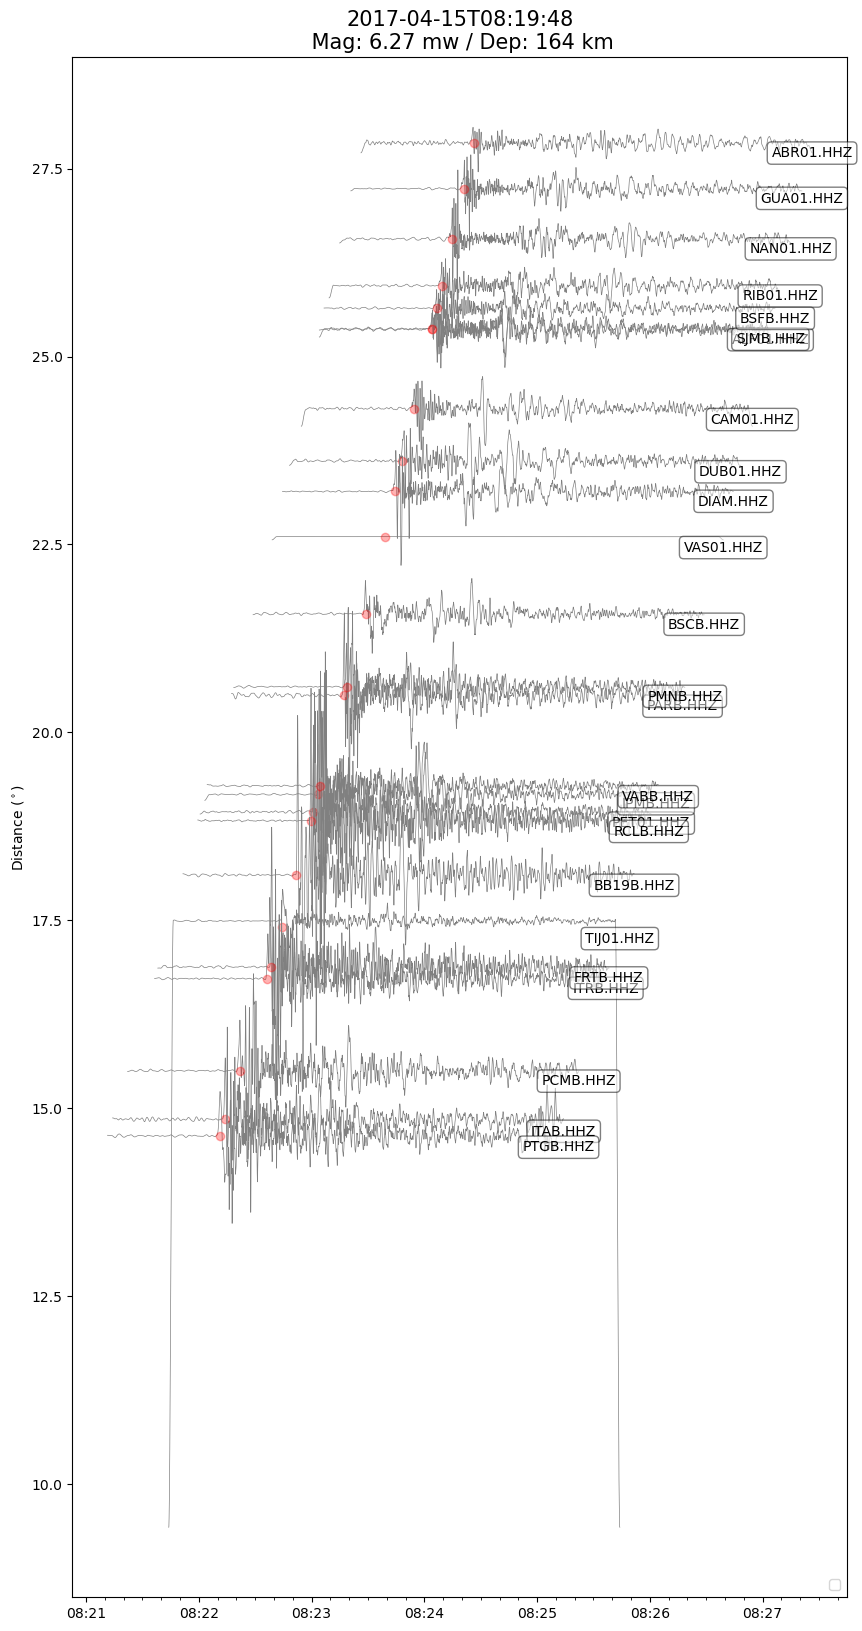

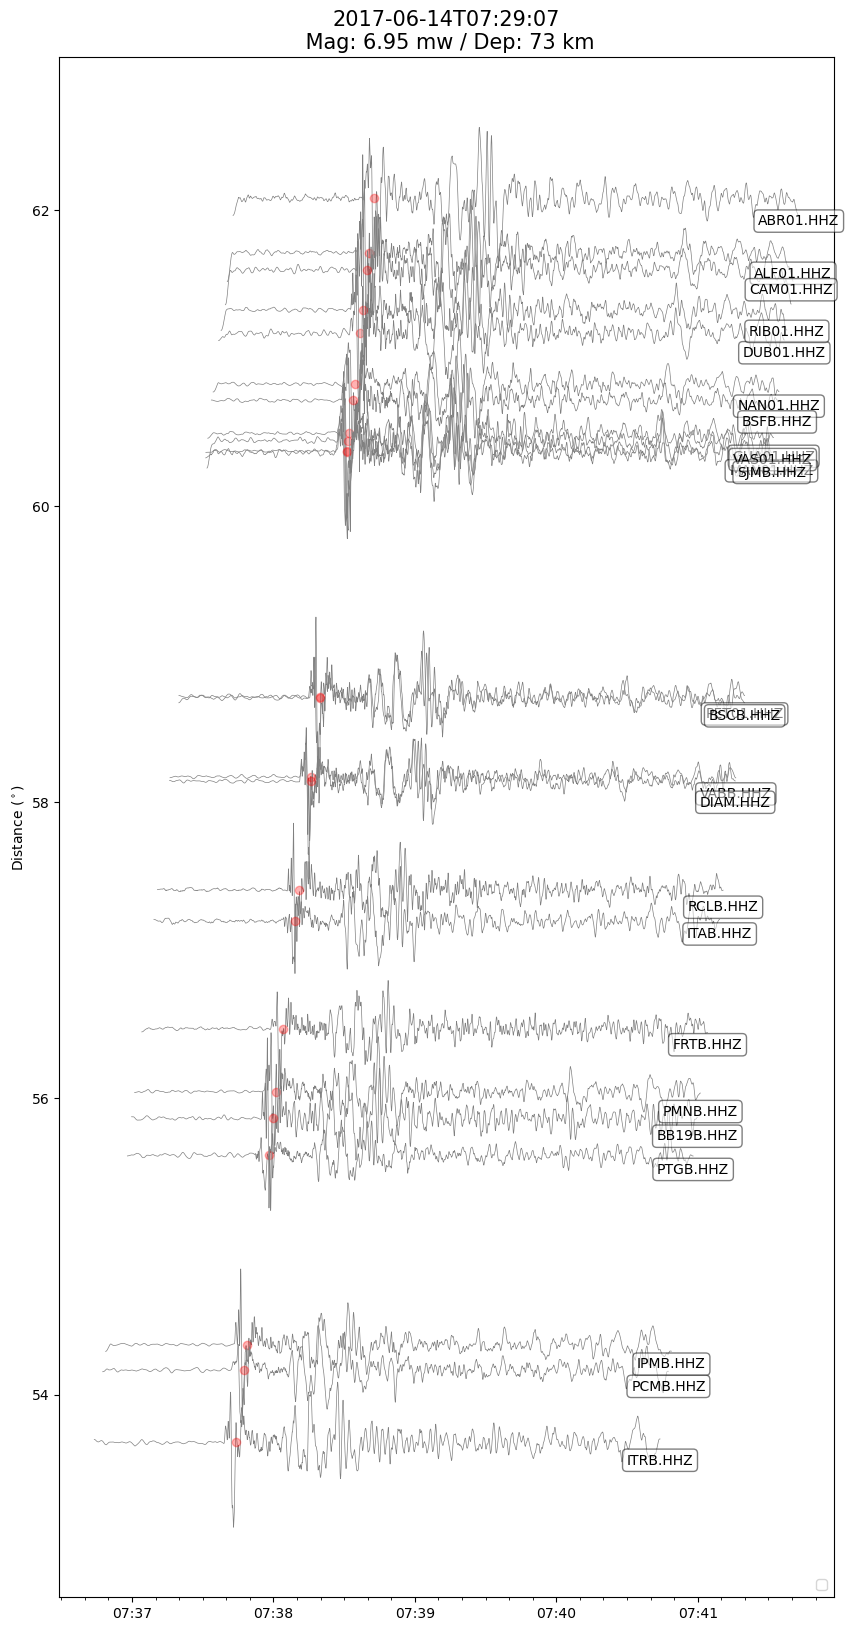

In [125]:
#########################################################################################################################################################
#Figure REGIONAL

# Matching the events files with the catalog:
cat = obspy.read_events(QUAKEXML_FOLDER+'CMTSOLUTIONS')
model = TauPyModel(model="iasp91")

for id,st_p in enumerate(st_ev_lst):
    cat2 = cat.filter("time >= "+UTCDateTime.strftime(ev_time_UTC_lst[id]-60,format='%Y-%m-%dT%H:%M:%S'),"time <= "+UTCDateTime.strftime(ev_time_UTC_lst[id]+60,format='%Y-%m-%dT%H:%M:%S'))
    if len(cat2) > 0:
        ev = cat2[0]
        event = ev.origins[0].time
        ev_lat = ev.origins[0].latitude
        ev_long = ev.origins[0].longitude
        ev_depth = ev.origins[0].depth/1000
   
        # set up the plot and create a GeoAxes:
        fig = plt.figure(figsize=(10,20))
        ax = fig.add_subplot()
        for st_plot in st_p:
            st_plot.filter('lowpass',freq=3,corners=4,zerophase=True)
            st_plot.taper(max_percentage=0.01)
            st_plot.detrend('linear')
            st_plot.detrend('demean')
            
            #Event time at each station
            #Calculating distance, azimuth and backazimuth
            dist,az,baz = obspy.geodetics.gps2dist_azimuth(ev_lat,ev_long,st_plot.stats.sac.stla,st_plot.stats.sac.stlo)
            gcarc = obspy.geodetics.kilometer2degrees(dist/1000)
            arrival = model.get_travel_times(source_depth_in_km=ev_depth,distance_in_degree=gcarc,phase_list=["P"])
            event_time = event+arrival[0].time

            times = [mdates.date2num((event+arrival[0].time)+(i-60)) for i in st_plot.times()]

            ax.plot(times,gcarc+st_plot.data/10**4.3,c='grey',ls='-',lw=0.5)
            ax.plot(mdates.date2num(event_time),gcarc,'or',alpha=0.3)
            ax.text(x=times[-1],y=st_plot.stats.sac.gcarc,s=st_plot.stats.station+'.'+st_plot.stats.channel,ha="center",va="center",bbox=dict(boxstyle="round",ec='k',fc='w',alpha=0.5))
        
        for st_glider_plot in st_glider_ev_lst[id]:
            st_glider_plot.filter('lowpass',freq=3,corners=4,zerophase=True)
            st_glider_plot.taper(max_percentage=0.01)
            st_glider_plot.detrend('linear')
            st_glider_plot.detrend('demean')

            #Event time at each station
            #Calculating distance, azimuth and backazimuth
            dist,az,baz = obspy.geodetics.gps2dist_azimuth(ev_lat,ev_long,st_glider_plot.stats.sac.stla,st_glider_plot.stats.sac.stlo)
            gcarc = obspy.geodetics.kilometer2degrees(dist/1000)
            arrival = model.get_travel_times(source_depth_in_km=ev_depth,distance_in_degree=gcarc,phase_list=["P"])
            event_time = event+arrival[0].time

            times_glider = [mdates.date2num(event_time+(i-30)) for i in st_glider_plot.times()]

            ax.plot(times_glider,gcarc+st_glider_plot.data/10**(ev.magnitudes[0].mag+0.5),c='k',ls='-',lw=0.5)
            ax.plot(mdates.date2num(event_time),gcarc,'or',alpha=0.3,label='P-wave arrival')
            ax.text(x=times_glider[-1],y=gcarc,s=st_glider_plot.stats.station+'.'+st_glider_plot.stats.channel,ha="left",va="center",bbox=dict(boxstyle="round",ec='k',fc='r',alpha=0.75))
            
        ax.set_title(ev.origins[0].time.strftime('%Y-%m-%dT%H:%M:%S')+'\n Mag: '+str(ev.magnitudes[0].mag)+' '+ev.magnitudes[0].magnitude_type+' / Dep: '+str(round(ev_depth))+' km',fontsize=15)
        ax.set_ylabel('Distance ($^\circ$)')
        ax.legend(loc='lower right')
        ax.xaxis.set_major_locator(mdates.SecondLocator(interval=60))
        ax.xaxis.set_minor_locator(mdates.SecondLocator(interval=10))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
        
    # ----------------------------------------------------------------------------------------------------------
    # Saving figure
    os.makedirs(FOLDER_OUTPUT+'EVENTS/FIGURES/',exist_ok=True)
    fig.savefig(FOLDER_OUTPUT+'EVENTS/FIGURES/'+'event_mseed_'+ev.origins[0].time.strftime('%Y_%m_%d_%H_%M_%S')+'_'+ev.event_descriptions[0].text+'.png',pad_inches=0.01,dpi=100)
    #plt.close()


In [151]:
#########################################################################################################################################################
#Figure LOCAL

# Matching the events files with the catalog:
cat = obspy.read_events(QUAKEXML_FOLDER+'CMTSOLUTIONS')
model = TauPyModel(model="iasp91")

for id,st_p in enumerate(st_ev_lst):
    events = pd.read_csv(LOCAL_EVENTS_TABLE,sep=',')
    events['time'] = events.apply(lambda row: UTCDateTime(row.origin), axis=1)
    
    ev_file = events[(events['time'] >= (ev_time_UTC_lst[id]-60)) & (events['time'] <= (ev_time_UTC_lst[id]+60))]

    if len(ev_file) > 0 and len(st_glider_ev_lst[id]) > 0:
        event = ev_file['time'].values[0]
        ev_lat = ev_file.latitude.values[0]
        ev_long = ev_file.longitude.values[0]
        ev_depth = ev_file.depth.values[0]
        #if ev_depth == 0:
            #ev_depth = 10
        ev_mag =  ev_file.magnitude.values[0]
        
           
        # set up the plot and create a GeoAxes:
        fig = plt.figure(figsize=(10,20))
        ax = fig.add_subplot()
        for st_plot in st_p:
            st_plot.filter('bandpass',freqmin=1,freqmax=10,corners=4,zerophase=True)
            st_plot.taper(max_percentage=0.02)
            st_plot.detrend('linear')
            st_plot.detrend('demean')
            
            #Event time at each station
            #Calculating distance, azimuth and backazimuth
            dist,az,baz = obspy.geodetics.gps2dist_azimuth(ev_lat,ev_long,st_plot.stats.sac.stla,st_plot.stats.sac.stlo)            
            gcarc = obspy.geodetics.kilometer2degrees(dist/1000)
            arrival = model.get_travel_times(source_depth_in_km=ev_depth,distance_in_degree=gcarc,phase_list=["P"])
            
            
            event_time = event+arrival[0].time

            times = [mdates.date2num((event+arrival[0].time)+(i-60)) for i in st_plot.times()]

            ax.plot(times,gcarc+st_plot.data/10**3.5,c='grey',ls='-',lw=0.5)
            ax.plot(mdates.date2num(event_time),gcarc,'or',alpha=0.3,label='P-wave arrival')
            ax.text(x=times[-1],y=st_plot.stats.sac.gcarc,s=st_plot.stats.station+'.'+st_plot.stats.channel,ha="center",va="center",bbox=dict(boxstyle="round",ec='k',fc='w',alpha=0.5))
        
        for st_glider_plot in st_glider_ev_lst[id]:
            st_glider_plot.filter('bandpass',freqmin=1,freqmax=10,corners=4,zerophase=True)
            st_glider_plot.taper(max_percentage=0.02)
            st_glider_plot.detrend('linear')
            st_glider_plot.detrend('demean')

            #Event time at each station
            #Calculating distance, azimuth and backazimuth
            dist,az,baz = obspy.geodetics.gps2dist_azimuth(ev_lat,ev_long,st_glider_plot.stats.sac.stla,st_glider_plot.stats.sac.stlo)
            print(dist/1000)
            #Calculating arrival times
            command = 'cake arrivals --model='+MODEL_CAKE+' --sdepth='+str(10)+' --rdepth='+str((-1)*round(st_glider_plot.stats.sac.stel/1000,2))+' --distances='+str(round(dist/1000,2))+" --phases='p(seafloor)p,s(seafloor)p,s(seafloor)p^Pv(seafloor)p^Pv(seafloor)p^Pv(seafloor)p^Pv(seafloor)p^Pv(seafloor)p^Pv(seafloor)p^Pv(seafloor)p^Pv(seafloor)p^Pv(seafloor)p^Pv(seafloor)p^Pv(seafloor)p^Pv(seafloor)p^P\\'"
            proc = subprocess.Popen(command, stdout=subprocess.PIPE, shell=True,text=True)
            (out, err) = proc.communicate()
            results = out.splitlines()
            
            print(results)

            event_time = UTCDateTime(event)+float(results[3].split(' ')[2])
            eventS = UTCDateTime(event)+float(results[4].split(' ')[2])
            eventT = UTCDateTime(event)+float(results[5].split(' ')[2])

            times_glider = [mdates.date2num(event_time+(i-30)) for i in st_glider_plot.times()]

            ax.plot(times_glider,gcarc+st_glider_plot.data/10**7.5,c='k',ls='-',lw=0.5)
            ax.plot(mdates.date2num(event_time),gcarc,'or',alpha=0.3,label='P-wave arrival')
            ax.plot(mdates.date2num(eventS),gcarc,'og',alpha=0.3,label='S-wave arrival')
            ax.plot(mdates.date2num(eventT),gcarc,'ob',alpha=0.3,label='T-wave arrival')
            ax.text(x=times_glider[-1],y=gcarc,s=st_glider_plot.stats.station+'.'+st_glider_plot.stats.channel,ha="left",va="center",bbox=dict(boxstyle="round",ec='k',fc='r',alpha=0.75))
            
        ax.set_title(event.strftime('%Y-%m-%dT%H:%M:%S')+'\n Mag: '+str(ev_mag)+' '+events['magnitudet'].values[0]+' / Dep: '+str(round(ev_depth))+' km',fontsize=15)
        ax.set_ylabel('Distance ($^\circ$)')
        ax.legend(loc='lower right')
        ax.xaxis.set_major_locator(mdates.SecondLocator(interval=60))
        ax.xaxis.set_minor_locator(mdates.SecondLocator(interval=10))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
        
    # ----------------------------------------------------------------------------------------------------------
    # Saving figure
    os.makedirs(FOLDER_OUTPUT+'EVENTS/FIGURES/',exist_ok=True)
    fig.savefig(FOLDER_OUTPUT+'EVENTS/FIGURES/'+'event_mseed_'+ev_time_UTC_lst[id].strftime('%Y_%m_%d_%H_%M_%S')+'_'+events['evid'].values[0]+'.png',pad_inches=0.01,dpi=100)
    plt.close()


97.67161636636494
['slow    dist  time   take inci effi spre phase             used             ', 's/km    km    s      deg  deg  %    %   ', '----------------------------------------------------------------------------', '0.17173 97.67 18.185 94.0 14.4 17.3 8.82 p(seafloor)p      (p)              ', '0.31125 97.67 31.783 94.0 26.8 14.1 9.66 s(seafloor)p      (s2.5p)          ', '0.31012 97.67 68.155 96.3  153 1e-20 20.0 s(seafloor)p^Pv(seafloor)p^Pv(seafloor)p^Pv(seafloor)p^Pv(seafloor)p^Pv(seafloor)p^Pv(seafloor)p^Pv(seafloor)p^Pv(seafloor)p^Pv(seafloor)p^Pv(seafloor)p^Pv(seafloor)p^Pv(seafloor)p^P\\ (s2.5p^0Pv2.5p^0Pv2.5p^0Pv2.5p^0Pv2.5p^0Pv2.5p^0Pv2.5p^0Pv2.5p^0Pv2.5p^0Pv2.5p^0Pv2.5p^0Pv2.5p^0Pv2.5p^0P\\)']


## 